## Chest X-Ray pneumonia detection

### change log
1. dropout from 0.25 to 0.5
2. each conv2D with stride (2,2) instead of (1,1)
3. kernal_size (10,10)
4. epoch=20
5. resize=128

### Import library
Here we import necessary libraries

In [1]:
import keras
import numpy as np

#from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import glob
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import os
%matplotlib inline

### Access the image files
We use the chest X ray images as the input.

In [2]:
test_path = './data/chest_xray/test/'
train_path = './data/chest_xray/train/'
label_normal = 'NORMAL/'
label_pneumonia = 'PNEUMONIA/'

### Read and explore the image files

In [3]:
suffix = '*.jpeg'
normal_train_path = train_path + label_normal + suffix
pneumonia_train_path = train_path + label_pneumonia + suffix
normal_test_path = test_path + label_normal + suffix
pneumonia_test_path = test_path + label_pneumonia + suffix
normal_train_name_list = glob.glob(normal_train_path)
pneumonia_train_name_list = glob.glob(pneumonia_train_path)
normal_test_name_list = glob.glob(normal_test_path)
pneumonia_test_name_list = glob.glob(pneumonia_test_path)

In [4]:
# Generate image array

def get_image_array(name_list):
    img_array = []
    for name in name_list:
        img = plt.imread(name)
        img_array.append(img)
    return np.array(img_array, dtype='object')

In [5]:
normal_train_img = get_image_array(normal_train_name_list)
normal_test_img = get_image_array(normal_test_name_list)
pneumonia_train_img = get_image_array(pneumonia_train_name_list)
pneumonia_test_img = get_image_array(pneumonia_test_name_list)

In [6]:
print('The normal train image size is {}'.format(normal_train_img.shape[0]))
print('The pneumonia train image size is {}'.format(pneumonia_train_img.shape[0]))
print('The normal test image size is {}'.format(normal_test_img.shape[0]))
print('The pneumonia test image size is {}'.format(pneumonia_test_img.shape[0]))

The normal train image size is 922
The pneumonia train image size is 2740
The normal test image size is 206
The pneumonia test image size is 390


### Prepare the image data
First of all we prepare the validation set in addition to train set and test set.

In [7]:
# # Create validation set
# # Concat 2 train arrays as a whole train set
# arr1 = normal_train_name_list.copy()
# arr2 = pneumonia_train_name_list.copy()
# # The complete train set
# arr1.extend(arr2)
# print('The train set contains {} chest X_Ray images'.format(len(arr1)))

# # Spin out validation set from the train set
# # 30%
# train_image_set, validation_image_set = train_test_split(arr1, test_size=0.3, shuffle=True, random_state=42)
# print('The new train set contains {} chest X_Ray images'.format(len(train_image_set)))
# print('The new validation set contains {} chest X_Ray images'.format(len(validation_image_set)))

# # print(validation_image_set)

# # Need to move validation set to validation folder
# # Cut and paste
# print('./data/chest_xray/train/NORMAL\\NORMAL-263932-0001.jpeg'.replace('train', 'validate'))

In [8]:
validate_path = './data/chest_xray/validate/'
test_path = './data/chest_xray/test/'

In [9]:
# for source in validation_image_set:
#     dest = source.replace('train', 'validate')
#     os.rename(source, dest)

normal_validate_path = validate_path + label_normal + suffix
pneumonia_validate_path = validate_path + label_pneumonia + suffix
normal_validate_name_list = glob.glob(normal_validate_path)
pneumonia_validate_name_list = glob.glob(pneumonia_validate_path)
normal_validate_img = get_image_array(normal_validate_name_list)
pneumonia_validate_img = get_image_array(pneumonia_validate_name_list)
print('The normal validate image size is {}'.format(normal_validate_img.shape[0]))
print('The pneumonia validate image size is {}'.format(pneumonia_validate_img.shape[0]))

The normal validate image size is 427
The pneumonia validate image size is 1143


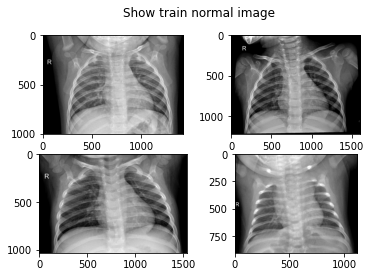

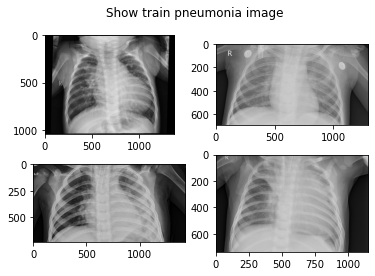

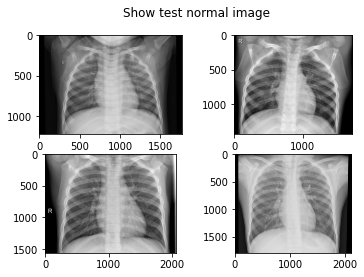

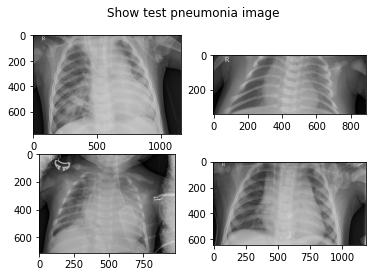

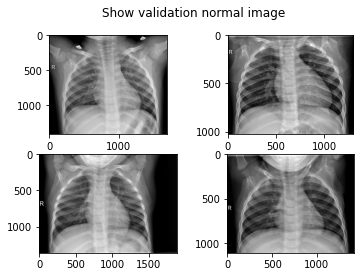

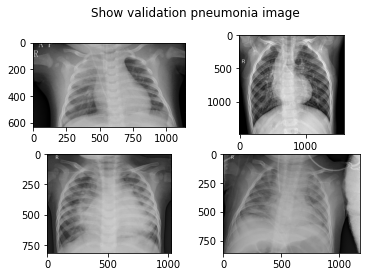

In [10]:
def show_sample_image(image_array, title):
    plt.figure()
    plt.suptitle(title)
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(image_array[random.randrange(200)], cmap='gray')

show_sample_image(normal_train_img, 'Show train normal image')
show_sample_image(pneumonia_train_img, 'Show train pneumonia image')

show_sample_image(normal_test_img, 'Show test normal image')
show_sample_image(pneumonia_test_img, 'Show test pneumonia image')

show_sample_image(normal_validate_img, 'Show validation normal image')
show_sample_image(pneumonia_validate_img, 'Show validation pneumonia image')

### Refactor the image files
Here we use Tensorflow ImageDataGenerator to refactor and resize the image files.
train_path; test_path; validate_path

In [11]:
# ImageDataGenerator for train set
IMAGE_SIZE = 50
BATCH = 32
train_img_datagen = ImageDataGenerator(rescale=1./IMAGE_SIZE,
                                       zoom_range = 0.1, 
                                       width_shift_range = 0.1,
                                       height_shift_range = 0.1
                                      )
# Load and refactor the train set images
train_source = train_img_datagen.flow_from_directory(train_path,
                                             #directory=train_path, #dataframe contains the full paths
                                             target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = 42,
                                                    shuffle=False)

# ImageDataGenerator for validation set
valid_img_datagen = ImageDataGenerator(rescale=1./IMAGE_SIZE)
# Load and refactor the validation set images
validation_source = valid_img_datagen.flow_from_directory(validate_path,
                                                          target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                          class_mode = 'binary',
                                                          batch_size = BATCH,
                                                          seed = 42,
                                                         shuffle=False)

# ImageDataGenerator for test set
test_img_datagen = ImageDataGenerator(rescale=1./IMAGE_SIZE)
# Load and refactor the test set images
test_source = test_img_datagen.flow_from_directory(test_path,
                                                   target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                   class_mode = 'binary',
                                                   batch_size = BATCH,
                                                   seed = 42,
                                                  shuffle=False)
print(train_source)
print('train image shape is {}'.format(train_source.image_shape))
print(validation_source)
print('validation image shape is {}'.format(validation_source.image_shape))
print(test_source)
print('test image shape is {}'.format(test_source.image_shape))

Found 3662 images belonging to 2 classes.
Found 1570 images belonging to 2 classes.
Found 596 images belonging to 2 classes.
train image shape is (50, 50, 3)
validation image shape is (50, 50, 3)
test image shape is (50, 50, 3)


### Prepare the model
Here we prepare the CNN model.

In [12]:
# #Input shape = [width, height, color channels]
# inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# # Block One
# x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)
# x = layers.MaxPool2D()(x)
# x = layers.Dropout(0.2)(x)

# # Block Two
# x = layers.Conv2D(filters=32, kernel_size=3, padding='valid')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)
# x = layers.MaxPool2D()(x)
# x = layers.Dropout(0.2)(x)

# # Block Three
# x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
# x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)
# x = layers.MaxPool2D()(x)
# x = layers.Dropout(0.4)(x)

# # Head
# #x = layers.BatchNormalization()(x)
# x = layers.Flatten()(x)
# x = layers.Dense(64, activation='relu')(x)
# x = layers.Dropout(0.5)(x)

# #Final Layer (Output)
# output = layers.Dense(1, activation='sigmoid')(x)

# model = keras.Model(inputs=[inputs], outputs=output)

In [13]:
# CNN using Keras' Sequential capabilities
FILTERS = 32

model = Sequential()

## 5x5 convolution with 1x1 stride and 32 filters
model.add(Conv2D(16, (5,5), strides = (1,1), padding='valid',
                 input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Activation('relu'))

## Another 5x5 convolution with 1x1 stride and 32 filters
model.add(Conv2D(32, (5,5), strides = (2,2), padding='valid'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Activation('relu'))

## The 3rd 5x5 convolution with 1x1 stride and 32 filters
model.add(Conv2D(64, (5,5), strides = (2,2), padding='valid'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Activation('relu'))

## 2x2 max pooling reduces to 3 x 3 x 32
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

## Flatten turns 3x3x32 into 288x1
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# model.add(Dense(2))
# model.add(Activation('softmax'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',optimizer = Adam(learning_rate=0.000003), metrics='binary_accuracy')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 16)        1216      
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 16)        64        
_________________________________________________________________
dropout (Dropout)            (None, 46, 46, 16)        0         
_________________________________________________________________
activation (Activation)      (None, 46, 46, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 32)        12832     
_________________________________________________________________
batch_normalization_1 (Batch (None, 21, 21, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 21, 32)        0

### Fit the model

In [14]:
len(train_source.filenames)

3662

In [15]:
# Fit the model
# adjust batch size from 16 to 256 to 300
history = model.fit(train_source,
#           batch_size = 16, 
                    epochs = 300,
          validation_data=validation_source,
          steps_per_epoch=(len(train_source.filenames)/32),
          validation_steps=(len(validation_source.filenames)/32))

Epoch 1/300
114/114 [==============================] - 45s 388ms/step - loss: 1.2314 - binary_accuracy: 0.3839 - val_loss: 0.7575 - val_binary_accuracy: 0.2815
Epoch 2/300
114/114 [==============================] - 42s 371ms/step - loss: 1.1455 - binary_accuracy: 0.4072 - val_loss: 0.7286 - val_binary_accuracy: 0.3573
Epoch 3/300
114/114 [==============================] - 43s 373ms/step - loss: 1.1266 - binary_accuracy: 0.4113 - val_loss: 0.7032 - val_binary_accuracy: 0.4873
Epoch 4/300
114/114 [==============================] - 42s 366ms/step - loss: 1.0789 - binary_accuracy: 0.4361 - val_loss: 0.6841 - val_binary_accuracy: 0.5694
Epoch 5/300
114/114 [==============================] - 42s 364ms/step - loss: 1.0228 - binary_accuracy: 0.4664 - val_loss: 0.6664 - val_binary_accuracy: 0.6357
Epoch 6/300
114/114 [==============================] - 47s 410ms/step - loss: 1.0296 - binary_accuracy: 0.4555 - val_loss: 0.6535 - val_binary_accuracy: 0.6643
Epoch 7/300
114/114 [===================

Epoch 52/300
114/114 [==============================] - 48s 419ms/step - loss: 0.6700 - binary_accuracy: 0.6827 - val_loss: 0.5339 - val_binary_accuracy: 0.7255
Epoch 53/300
114/114 [==============================] - 49s 423ms/step - loss: 0.6807 - binary_accuracy: 0.6791 - val_loss: 0.5326 - val_binary_accuracy: 0.7255
Epoch 54/300
114/114 [==============================] - 48s 422ms/step - loss: 0.6424 - binary_accuracy: 0.6862 - val_loss: 0.5315 - val_binary_accuracy: 0.7255
Epoch 55/300
114/114 [==============================] - 47s 412ms/step - loss: 0.6373 - binary_accuracy: 0.6922 - val_loss: 0.5305 - val_binary_accuracy: 0.7268
Epoch 56/300
114/114 [==============================] - 48s 422ms/step - loss: 0.6394 - binary_accuracy: 0.6942 - val_loss: 0.5292 - val_binary_accuracy: 0.7261
Epoch 57/300
114/114 [==============================] - 48s 422ms/step - loss: 0.6618 - binary_accuracy: 0.6871 - val_loss: 0.5279 - val_binary_accuracy: 0.7268
Epoch 58/300
114/114 [============

Epoch 103/300
114/114 [==============================] - 49s 426ms/step - loss: 0.5617 - binary_accuracy: 0.7316 - val_loss: 0.4759 - val_binary_accuracy: 0.7363
Epoch 104/300
114/114 [==============================] - 48s 420ms/step - loss: 0.5594 - binary_accuracy: 0.7307 - val_loss: 0.4739 - val_binary_accuracy: 0.7363
Epoch 105/300
114/114 [==============================] - 48s 425ms/step - loss: 0.5633 - binary_accuracy: 0.7302 - val_loss: 0.4726 - val_binary_accuracy: 0.7363
Epoch 106/300
114/114 [==============================] - 48s 424ms/step - loss: 0.5763 - binary_accuracy: 0.7256 - val_loss: 0.4717 - val_binary_accuracy: 0.7363
Epoch 107/300
114/114 [==============================] - 48s 424ms/step - loss: 0.5521 - binary_accuracy: 0.7357 - val_loss: 0.4705 - val_binary_accuracy: 0.7376
Epoch 108/300
114/114 [==============================] - 48s 425ms/step - loss: 0.5604 - binary_accuracy: 0.7348 - val_loss: 0.4699 - val_binary_accuracy: 0.7376
Epoch 109/300
114/114 [=====

Epoch 204/300
114/114 [==============================] - 76s 659ms/step - loss: 0.4331 - binary_accuracy: 0.7971 - val_loss: 0.3702 - val_binary_accuracy: 0.8548
Epoch 205/300
114/114 [==============================] - 77s 672ms/step - loss: 0.4221 - binary_accuracy: 0.8031 - val_loss: 0.3693 - val_binary_accuracy: 0.8567
Epoch 206/300
114/114 [==============================] - 76s 663ms/step - loss: 0.4307 - binary_accuracy: 0.8026 - val_loss: 0.3685 - val_binary_accuracy: 0.8580
Epoch 207/300
114/114 [==============================] - 76s 664ms/step - loss: 0.4485 - binary_accuracy: 0.7949 - val_loss: 0.3675 - val_binary_accuracy: 0.8637
Epoch 208/300
114/114 [==============================] - 76s 667ms/step - loss: 0.4419 - binary_accuracy: 0.7903 - val_loss: 0.3666 - val_binary_accuracy: 0.8637
Epoch 209/300
114/114 [==============================] - 75s 661ms/step - loss: 0.4272 - binary_accuracy: 0.8023 - val_loss: 0.3656 - val_binary_accuracy: 0.8669
Epoch 210/300
114/114 [=====

In [16]:
# Evaluate the validation set scores.
score = model.evaluate(validation_source, steps = len(validation_source.filenames)/32, verbose = 0)
print('Val loss of validation set: {}'.format(score[0]),)
print('Val accuracy of validation set: {}'.format(score[1]))

Val loss of validation set: 0.293244332075119
Val accuracy of validation set: 0.9254776835441589


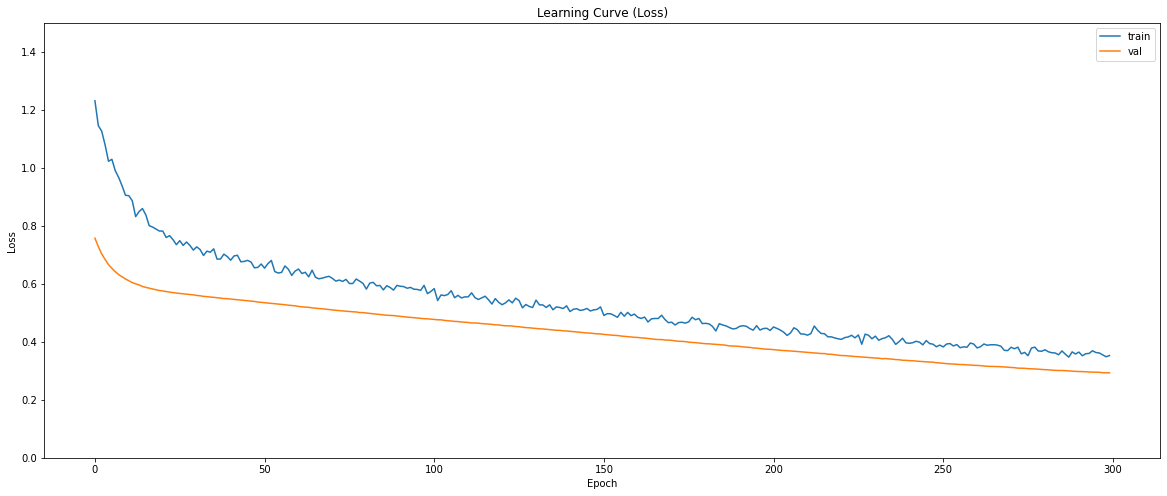

In [17]:
fig, ax = plt.subplots(figsize=(20,8))

plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss'])

ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

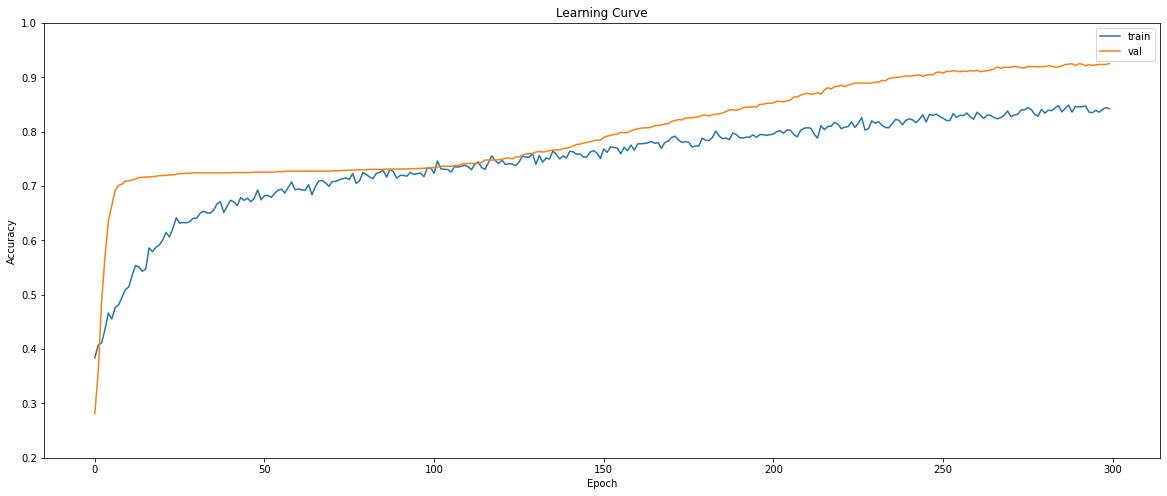

In [25]:
fig, ax = plt.subplots(figsize=(20,8))
plt.plot(history.epoch, history.history['binary_accuracy'])
plt.plot(history.epoch, history.history['val_binary_accuracy'])
ax.set_title('Learning Curve')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.20, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [19]:
# Evaluate the test set scores.
score = model.evaluate(test_source, steps = len(test_source.filenames)/32, verbose = 0)
print('Val loss of test set: {}'.format(score[0]),)
print('Val accuracy of test set: {}'.format(score[1]))

Val loss of test set: 0.36429446935653687
Val accuracy of test set: 0.8573825359344482


In [20]:
# Save the model
model.save('./data/pneumonia_model_copy3_1.h5')
print('model saved...')

model saved...


### Predict

In [21]:
# Predict each of the test images.
prediction = model.predict(test_source, 
#                            batch_size=len(test_source.filenames), 
#                            steps=len(test_source.filenames)/32, 
                           verbose=0)

# The true label values are between -1 and 1 due to sigmoid activation.
# Therefore by default we define label value > 0.5 as the possible penumonia image.
prediction_labels= np.where(prediction > 0.5, 1, 0)

### Evaluate the prediction

In [22]:
# Score the accuracy
# prediction_labels.shape
# len(test_source.filenames)
# strr='NORMAL\\NORMAL-2107985-0001.jpeg'
# print(strr.find('PNEUMONIA'))

true_labels = np.arange(len(test_source.filenames))
for idx, name in enumerate(test_source.filenames):
    if(name.find('NORMAL')!=-1):
        true_labels[idx] = 0
    else:
        true_labels[idx] = 1

# true_labels = np.arange(len(validation_source.filenames))
# for idx, name in enumerate(validation_source.filenames):
#     if(name.find('NORMAL')!=-1):
#         true_labels[idx] = 0
#     else:
#         true_labels[idx] = 1        

(596, 1)
0.8573825503355704


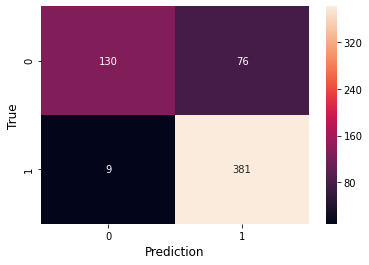

In [23]:
# i=0
# while i < len(test_source.filenames):
#     print(str(prediction_labels[i]) + ' -> ' + test_source.filenames[i])
#     i+=1
print(prediction_labels.shape)
print(accuracy_score(true_labels, prediction_labels))
confusion_matrix = confusion_matrix(true_labels, prediction_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")
plt.xlabel("Prediction", fontsize= 12)
plt.ylabel("True", fontsize= 12)
plt.show()

In [29]:
print('                 ====The classification report====')
print(classification_report(true_labels, prediction_labels, labels = [0, 1]))

                 ====The classification report====
              precision    recall  f1-score   support

           0       0.94      0.63      0.75       206
           1       0.83      0.98      0.90       390

    accuracy                           0.86       596
   macro avg       0.88      0.80      0.83       596
weighted avg       0.87      0.86      0.85       596

